In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install allennlp

In [3]:
import os
import random
import time
import datetime
import json
import pandas as pd
import numpy as np
import torch
import pickle
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import f1_score
import copy

In [4]:
# Load the config file
def load_config(config_path):
    # Load and parse the config file
    with open(config_path, 'r') as f:
        config = json.load(f)

    return config

#config = load_config('./HBiLSTM_CL.json')

In [5]:
from data import SequenceClassificationDataset

In [6]:
root = '/content/'
build_train_dataset = SequenceClassificationDataset(Path(root, 'train.json'))
build_dev_dataset = SequenceClassificationDataset(Path(root, 'dev.json'))
#cl_test_dataset = SequenceClassificationDataset(Path(root, 'test_scibert.json'))

In [7]:
batch_size=1
train_dataloader = DataLoader(build_train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(build_dev_dataset, batch_size=batch_size, shuffle=True)
#test_dataloader = DataLoader(cl_test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
from models import BertHSLN

In [14]:
BERT_MODEL = "bert-base-uncased"
mconfig = {
    "bert_model": BERT_MODEL,
    "bert_trainable": False,
    "model": BertHSLN.__name__,
    "cacheable_tasks": [],

    "dropout": 0.5,
    "word_lstm_hs": 384,
    "att_pooling_dim_ctx": 50,
    "att_pooling_num_ctx": 3,

    "lr": 3e-05,
    "lr_epoch_decay": 0.9,
    "batch_size":  32,
    "max_seq_length": 120,
    "max_epochs": 20,
    "early_stopping": 20,

}

In [15]:
torch.cuda.is_available()

True

In [16]:
# assign device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device used: {device}")

device used: cuda


In [20]:
model = BertHSLN(mconfig, num_labels = 7)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Attention pooling dim: 2304


In [21]:
lr = mconfig['lr']*4#config['training']['learning_rate']

In [22]:
seed_val = 42
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [23]:
# assign device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device used: {device}")
model.to(device)

device used: cuda


BertHSLN(
  (bert): BertTokenEmbedder(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
               

In [24]:
import functools
import operator

In [25]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

11857365

In [26]:
from allennlp.common.util import pad_sequence_to_length

def batch_to_tensor(b):
    # convert to dictionary of tensors and pad the tensors
    max_sentence_len = 128
    result = {}
    for k, v in b.items():

        if k in ["input_ids", "attention_mask"]:
            # determine the max sentence len in the batch
            max_sentence_len = -1
            for sentence in v:
                sentence = torch.cat(sentence)
                max_sentence_len = max(len(sentence), max_sentence_len)
            # pad the sentences to max sentence len
            for i, sentence in enumerate(v):
                v[i] = pad_sequence_to_length(sentence, desired_length=max_sentence_len)
        if k!='doc_name' and k!= 'label_ids':
            result[k] = torch.tensor(v).unsqueeze(0)
        elif k == 'label_ids':
            result[k] = torch.tensor(v)
        else:
            result[k] = v
    return result

In [27]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [32]:
from torch.optim.lr_scheduler import StepLR
from torch.optim import Adam

optimizer = Adam(list(model.parameters())), lr=lr)
epoch_scheduler = StepLR(optimizer, step_size=1, gamma=mconfig["lr_epoch_decay"])


In [1]:
def training_step(model, optimizer, scheduler, data_loader):
    model.train()  # Set the model to train mode
    train_loss = {'cls':0}
    train_correct = 0
    train_total = 0
    accum_iter = 5

    all_labels = []
    all_predicted = []

    for batch_idx, batch in enumerate(data_loader):
        batch = batch_to_tensor(batch)
        # handle an empty batch --> error in data preparation
        if batch["input_ids"].shape[1] == 0:
          continue


        for key, tensor in batch.items():
            batch[key] = tensor.to(device)
        #print(batch['input_ids'].shape)
        labels = batch['label_ids']
        #print(labels.shape)
        #optimizer.zero_grad()

        # Forward pass
        logits, embeddings = model(batch, labels, get_embeddings=True)

        logits = logits.squeeze()

        # Calculate loss
        classification_loss = F.cross_entropy(logits, labels.squeeze())
        #hard_triplet_loss = batch_hard_triplet_loss(labels, embeddings, 100.0, squared=True)
        train_loss['cls'] = train_loss['cls'] + classification_loss.detach().item()
        if batch_idx % 40 == 0:
          print(f'after {batch_idx} step: cls_loss {classification_loss}')



        # Backward pass and optimization
        loss = classification_loss 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()
    # Calculate epoch statistics
    train_loss['cls'] = train_loss['cls'] / len(data_loader)

    return train_loss


def validation_step(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    dev_loss = 0.0
    dev_correct = 0
    dev_total = 0
    all_labels = []
    all_predicted = []


    for batch in data_loader:
        # handle an empty batch --> error in data preparation
        with torch.no_grad():
            batch = batch_to_tensor(batch)
            if batch["input_ids"].shape[1] == 0:
              continue
            for key, tensor in batch.items():
               batch[key] = tensor.to(device)
            labels = batch['label_ids']
            # Forward pass
            logits = model(batch)


            # Calculate loss
            #print(logits.shape, labels.shape)
            dev_loss += F.cross_entropy(logits.squeeze(), labels.squeeze()).item()
            logits = logits.transpose(1, 2)
            predicted_label = torch.argmax(logits, dim=1)



            # save all epoch labels and predicted labels
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted_label.cpu().numpy())

    # Calculate epoch statistics
    all_predicted = functools.reduce(operator.iconcat, all_predicted, [])
    all_labels = functools.reduce(operator.iconcat, all_labels, [])
    f1 = f1_score(all_labels, all_predicted, average='weighted')
    dev_loss /= len(data_loader)
    return f1, dev_loss


In [2]:
train_epoch_losses = {'cls':[]}
train_epoch_acc = []
train_epoch_f1 = []

dev_epoch_losses = []
dev_epoch_acc = []
dev_epoch_f1 = []


best_dev_f1 = 0
best_model = None

epochs = 20

In [103]:
# Training loop
for epoch in range(epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))

    # Training
    train_loss = training_step(model, optimizer, epoch_scheduler, train_dataloader)
    train_epoch_losses['cls'].append(train_loss['cls'])
    print(f"Epoch {epoch+1}/{epochs} - Training CLS Loss: {train_loss['cls']:.4f}:.4f}")

    # Validation
    dev_f1, dev_loss = validation_step(model, valid_dataloader)
    dev_epoch_losses.append(dev_loss)
    dev_epoch_f1.append(dev_f1)
    print(f"Epoch {epoch+1}/{epochs} - dev loss {dev_loss} - F1 {dev_f1}")

    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        best_model = copy.deepcopy(model)
        print(f'saving the checkpoint with dev f1 - {best_dev_f1}')

======== Epoch 1 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 2.575805425643921, cluster_loss 0.7362509965896606
after 40 step: cls_loss 2.194828748703003, cluster_loss 0.423495888710022
after 80 step: cls_loss 1.4960018396377563, cluster_loss 0.5416814684867859
after 120 step: cls_loss 1.2352075576782227, cluster_loss 0.3569697141647339
after 160 step: cls_loss 1.5712149143218994, cluster_loss 0.2127150148153305
after 200 step: cls_loss 1.090552568435669, cluster_loss 0.4448174834251404
after 240 step: cls_loss 0.99507737159729, cluster_loss 0.25372856855392456
Epoch 1/30 - Training CLS Loss: 1.5192 - Train triplet Loss: 0.3834
Epoch 1/30 - dev loss 0.9470468352238337 - F1 0.65986210414555
saving the checkpoint with dev f1 - 0.65986210414555
======== Epoch 2 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.5627673268318176, cluster_loss 0.2797877788543701
after 40 step: cls_loss 0.7718698978424072, cluster_loss 0.35696956515312195
after 80 step: cls_loss 1.9864656925201416, cluster_loss 0.16326361894607544
after 120 step: cls_loss 0.9112324118614197, cluster_loss 0.3497343063354492
after 160 step: cls_loss 1.0686008930206299, cluster_loss 0.22025823593139648
after 200 step: cls_loss 1.5987244844436646, cluster_loss 0.35585469007492065
after 240 step: cls_loss 0.4909449815750122, cluster_loss 0.5176059007644653
Epoch 2/30 - Training CLS Loss: 0.9936 - Train triplet Loss: 0.3834
Epoch 2/30 - dev loss 0.875423076748848 - F1 0.6930833498268336
saving the checkpoint with dev f1 - 0.6930833498268336
======== Epoch 3 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.3106334209442139, cluster_loss 0.5448470711708069
after 40 step: cls_loss 0.8121282458305359, cluster_loss 0.3362399637699127
after 80 step: cls_loss 1.0694724321365356, cluster_loss 0.1437797099351883
after 120 step: cls_loss 0.294351190328598, cluster_loss 0.13284611701965332
after 160 step: cls_loss 0.915627121925354, cluster_loss 0.7058228254318237
after 200 step: cls_loss 0.49468162655830383, cluster_loss 0.3827377259731293
after 240 step: cls_loss 0.5651968121528625, cluster_loss 0.2817617654800415
Epoch 3/30 - Training CLS Loss: 0.8648 - Train triplet Loss: 0.3834
Epoch 3/30 - dev loss 0.7693065032362938 - F1 0.738748859405698
saving the checkpoint with dev f1 - 0.738748859405698
======== Epoch 4 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.315476894378662, cluster_loss 0.3147614300251007
after 40 step: cls_loss 0.9926228523254395, cluster_loss 0.22025835514068604
after 80 step: cls_loss 0.4724441468715668, cluster_loss 0.32960864901542664
after 120 step: cls_loss 0.5743687748908997, cluster_loss 0.47342097759246826
after 160 step: cls_loss 0.6372541189193726, cluster_loss 0.3296078145503998
after 200 step: cls_loss 0.71249920129776, cluster_loss 0.2531777024269104
after 240 step: cls_loss 0.8728533387184143, cluster_loss 0.8626800179481506
Epoch 4/30 - Training CLS Loss: 0.7520 - Train triplet Loss: 0.3834
Epoch 4/30 - dev loss 0.7693607494235039 - F1 0.7463125518216648
saving the checkpoint with dev f1 - 0.7463125518216648
======== Epoch 5 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.3170487582683563, cluster_loss 0.2797880470752716
after 40 step: cls_loss 0.5767911076545715, cluster_loss 0.3123481869697571
after 80 step: cls_loss 0.5066511034965515, cluster_loss 0.5434851050376892
after 120 step: cls_loss 0.41960057616233826, cluster_loss 0.3827369213104248
after 160 step: cls_loss 1.3889082670211792, cluster_loss 0.3925681412220001
after 200 step: cls_loss 1.1052119731903076, cluster_loss 0.3375701308250427
after 240 step: cls_loss 0.2496417760848999, cluster_loss 0.3623242676258087
Epoch 5/30 - Training CLS Loss: 0.6912 - Train triplet Loss: 0.3834
Epoch 5/30 - dev loss 0.749446073671182 - F1 0.7604583340824783
saving the checkpoint with dev f1 - 0.7604583340824783
======== Epoch 6 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.6084133982658386, cluster_loss 0.3588455319404602
after 40 step: cls_loss 0.8877578973770142, cluster_loss 0.5448471307754517
after 80 step: cls_loss 0.2576451897621155, cluster_loss 0.36971962451934814
after 120 step: cls_loss 1.0580968856811523, cluster_loss 0.31561484932899475
after 160 step: cls_loss 0.6822133660316467, cluster_loss 0.21717751026153564
after 200 step: cls_loss 0.661014199256897, cluster_loss 0.7362509965896606
after 240 step: cls_loss 0.937033474445343, cluster_loss 0.14580440521240234
Epoch 6/30 - Training CLS Loss: 0.6311 - Train triplet Loss: 0.3834
Epoch 6/30 - dev loss 0.7513756766915322 - F1 0.7620565285674341
saving the checkpoint with dev f1 - 0.7620565285674341
======== Epoch 7 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.8110432028770447, cluster_loss 0.4234980046749115
after 40 step: cls_loss 1.1227961778640747, cluster_loss 0.4852564334869385
after 80 step: cls_loss 0.6090878248214722, cluster_loss 0.13621222972869873
after 120 step: cls_loss 0.9326808452606201, cluster_loss 0.41173234581947327
after 160 step: cls_loss 0.49592331051826477, cluster_loss 0.4265997111797333
after 200 step: cls_loss 0.542133092880249, cluster_loss 0.5176064968109131
after 240 step: cls_loss 0.11026528477668762, cluster_loss 0.3722503185272217
Epoch 7/30 - Training CLS Loss: 0.5848 - Train triplet Loss: 0.3834
Epoch 7/30 - dev loss 0.71331285238266 - F1 0.7729668106773231
saving the checkpoint with dev f1 - 0.7729668106773231
======== Epoch 8 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.4512545168399811, cluster_loss 0.18988333642482758
after 40 step: cls_loss 0.4327753186225891, cluster_loss 0.4692583680152893
after 80 step: cls_loss 1.209503412246704, cluster_loss 0.16326333582401276
after 120 step: cls_loss 0.8277854323387146, cluster_loss 0.17501123249530792
after 160 step: cls_loss 0.2928120493888855, cluster_loss 0.1432485580444336
after 200 step: cls_loss 0.5791659951210022, cluster_loss 0.21271522343158722
after 240 step: cls_loss 0.6932029128074646, cluster_loss 0.4117315709590912
Epoch 8/30 - Training CLS Loss: 0.5590 - Train triplet Loss: 0.3834
Epoch 8/30 - dev loss 0.6886063491304716 - F1 0.7826738365914457
saving the checkpoint with dev f1 - 0.7826738365914457
======== Epoch 9 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.46515020728111267, cluster_loss 0.514488935470581
after 40 step: cls_loss 0.8055882453918457, cluster_loss 0.34717515110969543
after 80 step: cls_loss 1.0880755186080933, cluster_loss 0.5391720533370972
after 120 step: cls_loss 0.6400801539421082, cluster_loss 0.876589834690094
after 160 step: cls_loss 0.4702274799346924, cluster_loss 0.31476134061813354
after 200 step: cls_loss 0.16883538663387299, cluster_loss 0.36232444643974304
after 240 step: cls_loss 0.32252582907676697, cluster_loss 0.44481831789016724
Epoch 9/30 - Training CLS Loss: 0.5280 - Train triplet Loss: 0.3834
Epoch 9/30 - dev loss 0.7147142867247264 - F1 0.7776611158175336
======== Epoch 10 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.7513173222541809, cluster_loss 0.29298529028892517
after 40 step: cls_loss 0.4214554727077484, cluster_loss 0.2840520739555359
after 80 step: cls_loss 0.8120062351226807, cluster_loss 0.3064781129360199
after 120 step: cls_loss 0.562789261341095, cluster_loss 0.4234977960586548
after 160 step: cls_loss 0.1335000991821289, cluster_loss 0.2792850434780121
after 200 step: cls_loss 0.21764449775218964, cluster_loss 0.20704330503940582
after 240 step: cls_loss 0.1708439439535141, cluster_loss 0.3931189179420471
Epoch 10/30 - Training CLS Loss: 0.5011 - Train triplet Loss: 0.3834
Epoch 10/30 - dev loss 0.6915260511140029 - F1 0.7911833450753429
saving the checkpoint with dev f1 - 0.7911833450753429
======== Epoch 11 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.5654523372650146, cluster_loss 0.7237741351127625
after 40 step: cls_loss 0.5370109677314758, cluster_loss 0.3176225423812866
after 80 step: cls_loss 0.23958779871463776, cluster_loss 0.39612796902656555
after 120 step: cls_loss 0.07287862151861191, cluster_loss 0.41806691884994507
after 160 step: cls_loss 0.27939632534980774, cluster_loss 0.2772899270057678
after 200 step: cls_loss 0.2846701145172119, cluster_loss 0.2360706627368927
after 240 step: cls_loss 0.8485090732574463, cluster_loss 0.20036360621452332
Epoch 11/30 - Training CLS Loss: 0.4846 - Train triplet Loss: 0.3834
Epoch 11/30 - dev loss 0.7246609931190808 - F1 0.7779551219463214
======== Epoch 12 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.10419705510139465, cluster_loss 0.2890898585319519
after 40 step: cls_loss 0.44954782724380493, cluster_loss 0.6718926429748535
after 80 step: cls_loss 0.6947851777076721, cluster_loss 0.3471754491329193
after 120 step: cls_loss 0.3848472833633423, cluster_loss 0.2254094034433365
after 160 step: cls_loss 0.13779973983764648, cluster_loss 0.38820475339889526
after 200 step: cls_loss 0.1739346981048584, cluster_loss 0.6607751846313477
after 240 step: cls_loss 0.14651216566562653, cluster_loss 0.29115456342697144
Epoch 12/30 - Training CLS Loss: 0.4596 - Train triplet Loss: 0.3834
Epoch 12/30 - dev loss 0.6851259631415209 - F1 0.8008609381862778
saving the checkpoint with dev f1 - 0.8008609381862778
======== Epoch 13 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.17670674622058868, cluster_loss 0.13926665484905243
after 40 step: cls_loss 0.9273927211761475, cluster_loss 0.27242496609687805
after 80 step: cls_loss 0.6295353770256042, cluster_loss 0.2064920961856842
after 120 step: cls_loss 0.3178302049636841, cluster_loss 0.5794088840484619
after 160 step: cls_loss 0.19628509879112244, cluster_loss 0.39612799882888794
after 200 step: cls_loss 0.5243524312973022, cluster_loss 0.4196820855140686
after 240 step: cls_loss 0.08890202641487122, cluster_loss 0.5127219557762146
Epoch 13/30 - Training CLS Loss: 0.4394 - Train triplet Loss: 0.3834
Epoch 13/30 - dev loss 0.7337185353040695 - F1 0.7872652936878525
======== Epoch 14 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.7284616231918335, cluster_loss 0.5375152826309204
after 40 step: cls_loss 0.8973067402839661, cluster_loss 0.2605400085449219
after 80 step: cls_loss 0.17904295027256012, cluster_loss 0.13926656544208527
after 120 step: cls_loss 0.21446432173252106, cluster_loss 0.23607058823108673
after 160 step: cls_loss 0.6016647219657898, cluster_loss 0.7237734794616699
after 200 step: cls_loss 0.7112023234367371, cluster_loss 0.43133851885795593
after 240 step: cls_loss 0.6546207070350647, cluster_loss 0.8958576917648315
Epoch 14/30 - Training CLS Loss: 0.4211 - Train triplet Loss: 0.3834
Epoch 14/30 - dev loss 0.66724757005771 - F1 0.7955986634703588
======== Epoch 15 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.19093471765518188, cluster_loss 0.24262838065624237
after 40 step: cls_loss 0.6125449538230896, cluster_loss 0.723772406578064
after 80 step: cls_loss 0.3788456320762634, cluster_loss 0.33756881952285767
after 120 step: cls_loss 0.5515217781066895, cluster_loss 0.31820106506347656
after 160 step: cls_loss 0.26583170890808105, cluster_loss 0.18936753273010254
after 200 step: cls_loss 0.8683164715766907, cluster_loss 0.260540246963501
after 240 step: cls_loss 0.43160679936408997, cluster_loss 0.27199167013168335
Epoch 15/30 - Training CLS Loss: 0.4110 - Train triplet Loss: 0.3834
Epoch 15/30 - dev loss 0.7141392198701699 - F1 0.7899302010993328
======== Epoch 16 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.3988753855228424, cluster_loss 0.6470111012458801
after 40 step: cls_loss 0.5134255886077881, cluster_loss 0.7237719297409058
after 80 step: cls_loss 0.2743499279022217, cluster_loss 0.2019563764333725
after 120 step: cls_loss 0.47622719407081604, cluster_loss 0.1632636934518814
after 160 step: cls_loss 0.35966500639915466, cluster_loss 0.13621164858341217
after 200 step: cls_loss 0.4074588418006897, cluster_loss 0.7362500429153442
after 240 step: cls_loss 0.2524092495441437, cluster_loss 0.2700566053390503
Epoch 16/30 - Training CLS Loss: 0.4024 - Train triplet Loss: 0.3834
Epoch 16/30 - dev loss 0.7028248374660809 - F1 0.7994780622746263
======== Epoch 17 / 30 ========


<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.9636669754981995, cluster_loss 0.4265996515750885
after 40 step: cls_loss 0.18865272402763367, cluster_loss 0.49295759201049805
after 80 step: cls_loss 0.15342076122760773, cluster_loss 0.20649248361587524
after 120 step: cls_loss 0.3765753209590912, cluster_loss 1.1502362489700317


KeyboardInterrupt: ignored

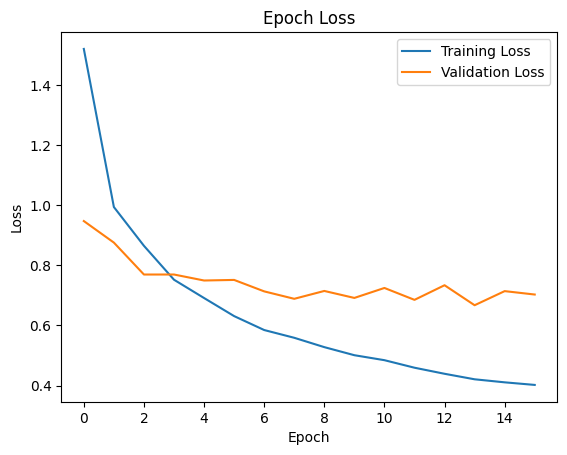

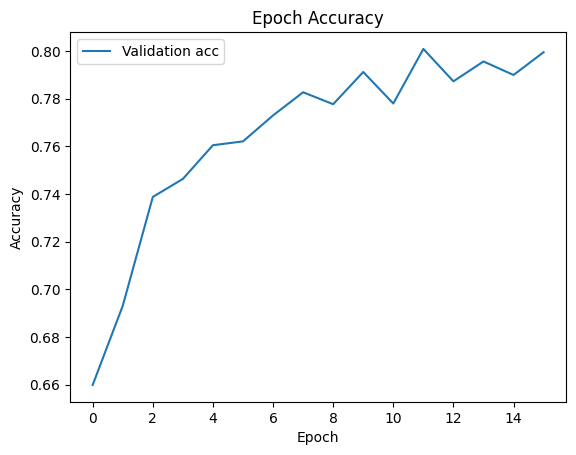

In [104]:
import matplotlib.pyplot as plt

# Plot the epoch loss
plt.plot(train_epoch_losses['cls'], label='Training Loss')
plt.plot(dev_epoch_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Epoch Loss')
plt.show()

# Plot the epoch accuracies
#plt.plot(train_epoch_acc, label='Training acc')
plt.plot(dev_epoch_f1, label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Epoch Accuracy')
plt.show()

In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [106]:
from sklearn.metrics import classification_report

def testing_step(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    model.to(device)

    for batch in data_loader:
        with torch.no_grad():

            batch = batch_to_tensor(batch)
            for key, tensor in batch.items():
               batch[key] = tensor.to(device)
            labels = batch['label_ids']
            # Forward pass
            logits = model(batch)
            #max_sequence_length = outputs.size(1)
            #tlengths = torch.tensor(lengths).unsqueeze(1)
            #mask = torch.arange(max_sequence_length).unsqueeze(0).to(device) < tlengths
            #masked_output = outputs[mask]
            logits = logits.transpose(1, 2)
            predicted_labels = torch.argmax(logits, dim=1)

            # Calculate loss
            #loss = criterion(masked_output, labels)
            #test_loss += loss.item()

            # Store predictions and true labels
            #predicted_labels = masked_output.argmax(dim=-1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Calculate accuracy
            predicted_labels = predicted_labels.to('cpu')
            labels = labels.to('cpu')


            correct = (predicted_labels == labels).sum().item()
            test_correct += correct
            test_total += labels.shape[0]

    predictions = functools.reduce(operator.iconcat, predictions, [])
    true_labels = functools.reduce(operator.iconcat, true_labels, [])

    test_loss /= len(data_loader)
    test_accuracy = test_correct / test_total

    print(f"Testing Loss: {test_loss:.4f} - Testing Accuracy: {test_accuracy:.4f}")
    print(classification_report(true_labels, predictions))
    return test_loss, test_accuracy, predictions, true_labels

In [108]:
test_loss, test_accuracy, predictions, true_labels = testing_step(model, valid_dataloader)

<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Testing Loss: 0.0000 - Testing Accuracy: 77.1667
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       508
           1       0.75      0.90      0.82       580
           2       0.61      0.19      0.29       116
           3       0.79      0.76      0.78        50
           4       0.37      0.16      0.22        70
           5       0.81      0.34      0.48        38
           6       0.78      0.84      0.81       984
           7       0.41      0.75      0.53        28
           8       0.79      0.39      0.53       142
           9       0.00      0.00      0.00        12
          10       0.53      0.56      0.55        70
          11       0.85      0.93      0.89        91
          12       0.92      0.91      0.91       190

    accuracy                           0.80      2879
   macro avg       0.66      0.59      0.60      2879
weighted avg       0.80      0.80      0.79      2879



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [109]:
test_loss, test_accuracy, predictions, true_labels = testing_step(best_model, valid_dataloader)

<ipython-input-95-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Testing Loss: 0.0000 - Testing Accuracy: 78.1333
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       508
           1       0.81      0.85      0.83       580
           2       0.62      0.34      0.44       116
           3       0.85      0.78      0.81        50
           4       0.46      0.27      0.34        70
           5       0.59      0.26      0.36        38
           6       0.77      0.89      0.82       984
           7       0.47      0.75      0.58        28
           8       0.81      0.36      0.50       142
           9       0.00      0.00      0.00        12
          10       0.58      0.56      0.57        70
          11       0.87      0.90      0.89        91
          12       0.93      0.89      0.91       190

    accuracy                           0.81      2879
   macro avg       0.67      0.60      0.62      2879
weighted avg       0.81      0.81      0.80      2879



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Testing loop
#test_loss, test_accuracy, predictions, true_labels = testing_step(model, test_dataloader)

<ipython-input-19-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Testing Loss: 0.0000 - Testing Accuracy: 169.4000
              precision    recall  f1-score   support

           0       0.60      0.59      0.59       326
           1       0.91      0.73      0.81       201
           2       0.53      0.31      0.39       256
           3       0.59      0.83      0.69       434
           4       0.00      0.00      0.00        23
           5       0.67      0.83      0.74        12
           6       0.74      0.66      0.70        86

    accuracy                           0.63      1338
   macro avg       0.58      0.57      0.56      1338
weighted avg       0.63      0.63      0.62      1338



In [ ]:
# Testing loop
#test_loss, test_accuracy, predictions, true_labels = testing_step(best_model, test_dataloader)

<ipython-input-19-29c5818d2fa6>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Testing Loss: 0.0000 - Testing Accuracy: 174.6000
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       326
           1       0.82      0.81      0.82       201
           2       0.56      0.41      0.47       256
           3       0.63      0.80      0.71       434
           4       0.00      0.00      0.00        23
           5       0.62      0.83      0.71        12
           6       0.71      0.70      0.70        86

    accuracy                           0.65      1338
   macro avg       0.57      0.59      0.57      1338
weighted avg       0.64      0.65      0.64      1338



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
